In [24]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [25]:
import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import Embedding
from src.rankings.listwise import ListwiseRanking
from src.utils.utilities import (
    sample_listwise,
    parquet_to_Dataset,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

In [26]:
# Load ratings dataset
ratings_dataset = parquet_to_Dataset(
    path = 'data/100k-ratings.parquet',
    exclude_columns = ['movie_genres']
)

# Load movies dataset
movies_dataset = parquet_to_Dataset(
    path = 'data/100k-movies.parquet',
    exclude_columns = ['movie_genres']
)

In [27]:
# Split ratings dataset into train and validation
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [28]:
ratings_trainset = sample_listwise(
    ratings_trainset,
    num_list_per_user=50,
    num_examples_per_list=5,
    seed=RANDOM_STATE
)

ratings_validset = sample_listwise(
    ratings_validset,
    num_list_per_user=1,
    num_examples_per_list=5,
    seed=RANDOM_STATE
)

In [35]:
# Create user embedding
user_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

# Create movie embedding
movie_embedding_model = Embedding(
    dataset = ratings_trainset.batch(1_000),
    str_features = ['movie_title'],
    int_features = [],
    text_features = [],
    timestamp_features = [],
    embedding_dim = 32,
)

In [36]:
candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    dense_layers = []
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    dense_layers = []
)

In [37]:
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(8192).cache()
cached_ratings_validset = ratings_validset.batch(4096).cache()

{'root_mean_squared_error': 0.9890748262405396, 'ndcg_metric': 0.9060510993003845, 'loss': 0.9782689809799194, 'regularization_loss': 0, 'total_loss': 0.9782689809799194}


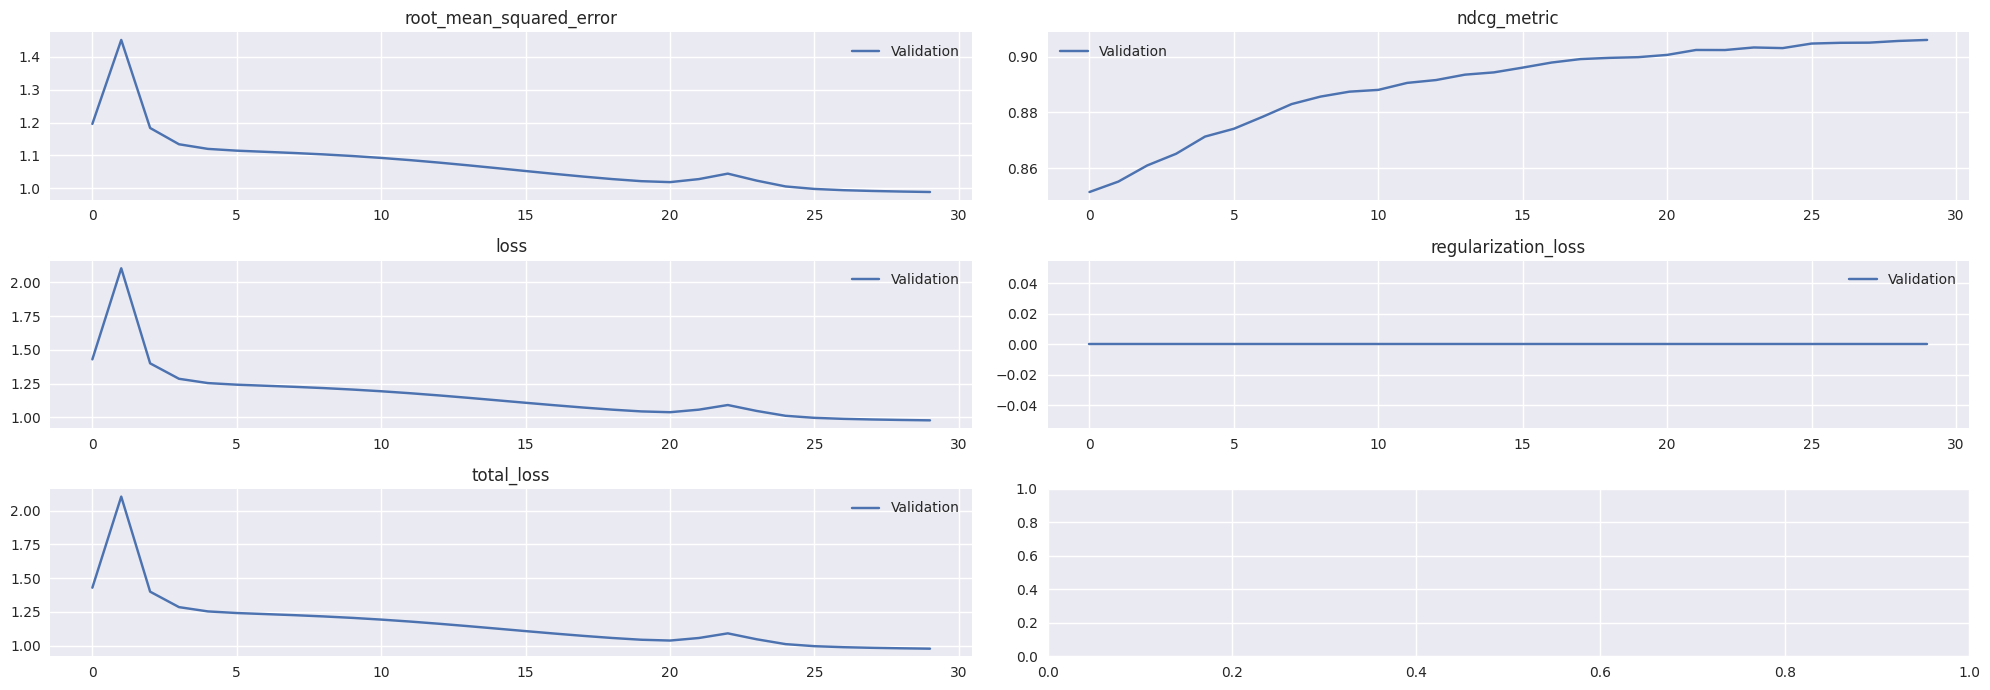

In [38]:
task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)

{'root_mean_squared_error': 3.2880473136901855, 'ndcg_metric': 0.9087396264076233, 'loss': 1.0224438905715942, 'regularization_loss': 0, 'total_loss': 1.0224438905715942}


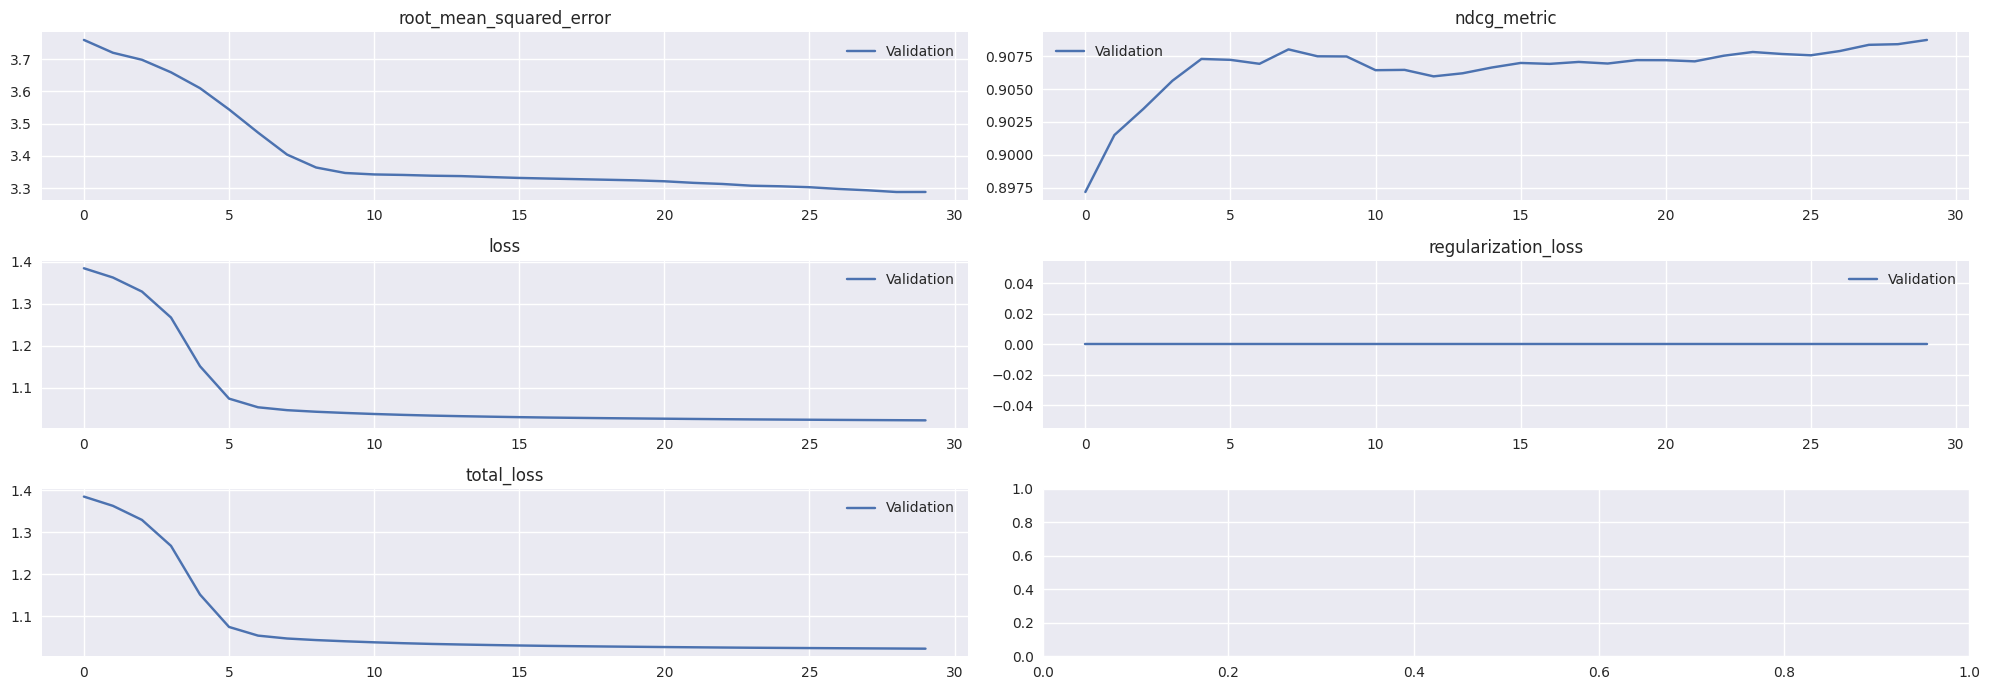

In [39]:
task = tfrs.tasks.Ranking(
    loss = tfr.keras.losses.PairwiseHingeLoss(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)

{'root_mean_squared_error': 3.874075174331665, 'ndcg_metric': 0.907270073890686, 'loss': 4.544214725494385, 'regularization_loss': 0, 'total_loss': 4.544214725494385}


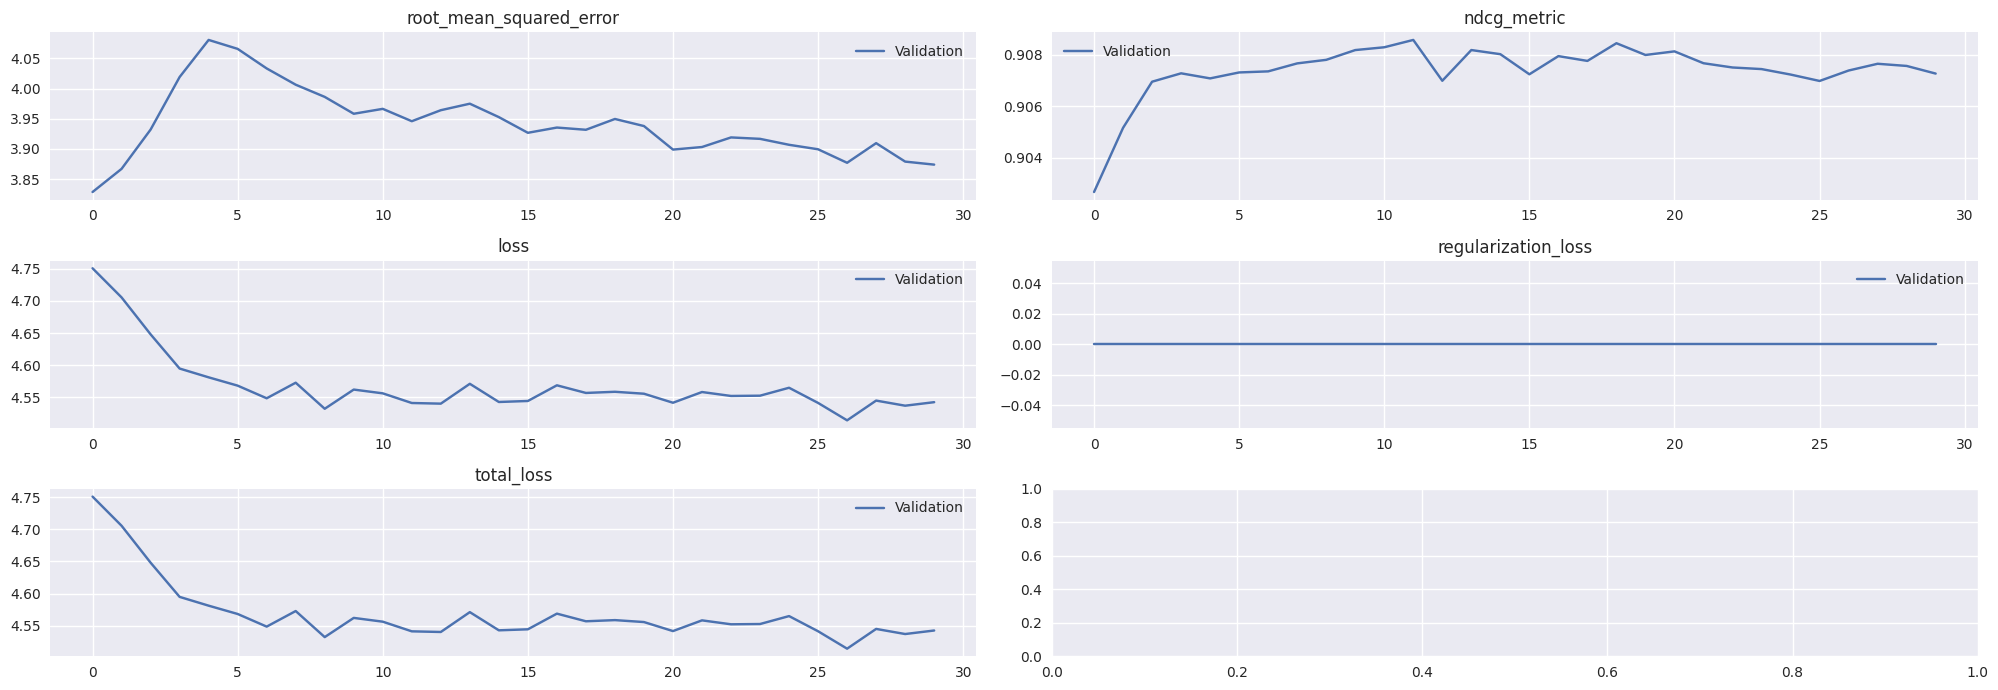

In [43]:
task = tfrs.tasks.Ranking(
    loss = tfr.keras.losses.ListMLELoss(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric"),
    ]
)

model = ListwiseRanking(query_tower, candidate_tower, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 30,
    verbose = False,
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)